In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from bnn_shson_rhograd_170824 import *
import nn_shson
from shson_exp_manager import *
import h5py
import random

%matplotlib inline


In [3]:
def num_to_onehot(nums, n_labels):
    results = list()
    for i in range(len(nums)):
        res = np.zeros([n_labels])
        res[nums[i]] = 1
        results.append(res)
    return np.asarray(results, dtype = 'float32')
        

In [4]:
mnist = h5py.File('mnist.hdf5', 'r')

random.seed(1337)

perm1 = range(784)
perm2 = range(784)
perm3 = range(784)
perm4 = range(784)
perm5 = range(784)
perm6 = range(784)

random.shuffle(perm1)
random.shuffle(perm2)
random.shuffle(perm3)
random.shuffle(perm4)
random.shuffle(perm5)
random.shuffle(perm6)

print perm1[0:20]
print perm2[0:20]

x_train = list()
x_valid = list()
x_test = list()

x_train.append(mnist['train_data'][()])
x_train.append(mnist['train_data'][()][:, perm1])
x_train.append(mnist['train_data'][()][:, perm2])
x_train.append(mnist['train_data'][()][:, perm3])
x_train.append(mnist['train_data'][()][:, perm4])
x_train.append(mnist['train_data'][()][:, perm5])
x_train.append(mnist['train_data'][()][:, perm6])
t_train = num_to_onehot(mnist['train_label'][()], 10)
x_valid.append(mnist['valid_data'][()])
x_valid.append(mnist['valid_data'][()][:, perm1])
x_valid.append(mnist['valid_data'][()][:, perm2])
x_valid.append(mnist['valid_data'][()][:, perm3])
x_valid.append(mnist['valid_data'][()][:, perm4])
x_valid.append(mnist['valid_data'][()][:, perm5])
x_valid.append(mnist['valid_data'][()][:, perm6])
t_valid = num_to_onehot(mnist['valid_label'][()], 10)
x_test.append(mnist['test_data'][()])
x_test.append(mnist['test_data'][()][:, perm1])
x_test.append(mnist['test_data'][()][:, perm2])
x_test.append(mnist['test_data'][()][:, perm3])
x_test.append(mnist['test_data'][()][:, perm4])
x_test.append(mnist['test_data'][()][:, perm5])
x_test.append(mnist['test_data'][()][:, perm6])
t_test = num_to_onehot(mnist['test_label'][()], 10)

mnist.close()


[290, 476, 531, 412, 667, 470, 656, 123, 167, 378, 357, 729, 324, 327, 271, 681, 155, 75, 755, 316]
[398, 598, 337, 481, 192, 554, 297, 296, 157, 72, 29, 778, 513, 407, 264, 420, 69, 508, 690, 504]


In [5]:
batch_size = 200

In [6]:
def print_accs(accs, ep):
    res = ""
    for acc in accs:
        res += " {:.4f}".format(acc[ep])
    
    print res

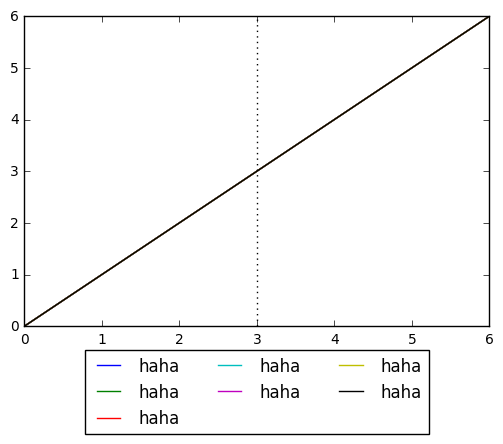

In [19]:
testarr = [0, 1, 2, 3, 4, 5, 6]
plt.plot(testarr)
plt.plot(testarr)
plt.plot(testarr)
plt.plot(testarr)
plt.plot(testarr)
plt.plot(testarr)
plt.plot(testarr)
plt.axvline(3, color = 'k', ls = ':')
plt.legend(['haha', 'haha', 'haha', 'haha', 'haha', 'haha', 'haha'], loc = "upper center", bbox_to_anchor=(0.5, -0.05), ncol = 3)

In [14]:
testlist1 = []
testlist1[-1]

IndexError: list index out of range

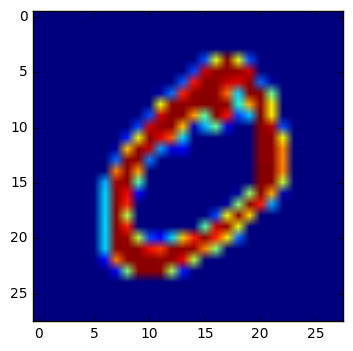

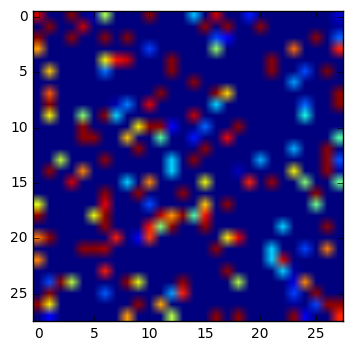

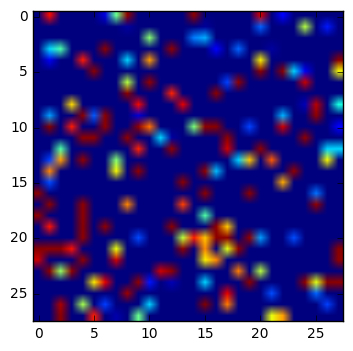

In [11]:
plt.imshow(np.reshape(x_train[0][1], (28, 28)))
plt.show()
plt.imshow(np.reshape(x_train[1][1], (28, 28)))
plt.show()
plt.imshow(np.reshape(x_train[2][1], (28, 28)))
plt.show()

# Blundell version

In [7]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [8]:
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-1.0, 5.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = True, train_rho = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

# train_writer = tf.train.SummaryWriter(savedir + 'train', sess.graph)
# test_writer = tf.train.SummaryWriter(savedir + 'test')

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')


layer done
layer done
(10, ?, 10)


In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())
    
for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):
        bnn.reset_klrw()

        for i in range(n_batches):
            
            bnn.decay_klrw()

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))
                
            bnn.train(feed)

        fs_mean.append(np.mean(fs[-n_batches:]))

        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
                
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))




In [ ]:
coeff_klrw = 1 / n_batches

plt.plot(fs, 'r')
plt.plot(qs*coeff_klrw, 'b')
plt.plot(ps*coeff_klrw, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')


plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
plt.title('Blundell\'s Bayesian NN')
plt.plot(taccs, 'k')
plt.plot(vaccs[0], 'tab:blue')
plt.plot(vaccs[1], 'tab:orange')
plt.plot(vaccs[2], 'tab:green')
plt.plot(vaccs[3], 'tab:red')
plt.plot(vaccs[4], 'tab:purple')
plt.plot(vaccs[5], 'tab:brown')
plt.plot(vaccs[6], 'tab:pink')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

# Online version

In [45]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [46]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

layer done
layer done
(10, ?, 10)


In [47]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            bnn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1


        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    bnn.update_prior()
    #bnn.print_params()




ep 0, batch 0, training accuracy 0.13
f : 202068.78125, q : 142556.625, p : -54963.875, l : 4608.43310547
ep 0, batch 50, training accuracy 0.88
f : 196564.25, q : 140581.265625, p : -55000.4960938, l : 1056.89733887
ep 0, batch 100, training accuracy 0.885
f : 194493.984375, q : 138569.0, p : -55023.8203125, l : 906.129638672
ep 0, batch 150, training accuracy 0.9
f : 192444.359375, q : 136465.296875, p : -55037.2617188, l : 814.578979492
ep 0, batch 200, training accuracy 0.93
f : 190209.21875, q : 134628.75, p : -55047.4570312, l : 523.012512207
valid accuracy: 0.9145 0.0916 0.0902 0.1231 0.0932 0.103 0.1025
valid accuracy: 0.9364 0.0977 0.0947 0.1163 0.0933 0.102 0.105
valid accuracy: 0.9457 0.1013 0.0991 0.1151 0.0948 0.0969 0.1048
valid accuracy: 0.9513 0.1022 0.0998 0.117 0.0976 0.0961 0.1037
valid accuracy: 0.9558 0.1021 0.0989 0.1163 0.0983 0.0946 0.1043
valid accuracy: 0.958 0.1012 0.0974 0.1115 0.0985 0.0907 0.1073
valid accuracy: 0.9588 0.1013 0.0974 0.1126 0.0981 0.0874 0.

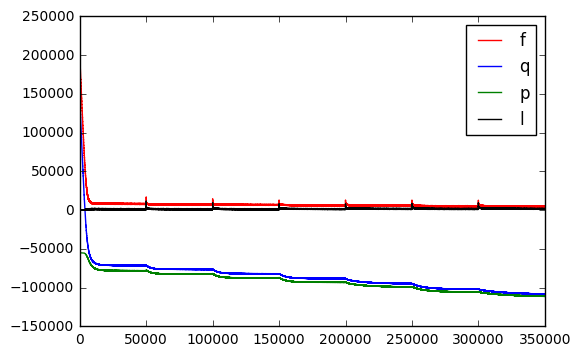

In [48]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

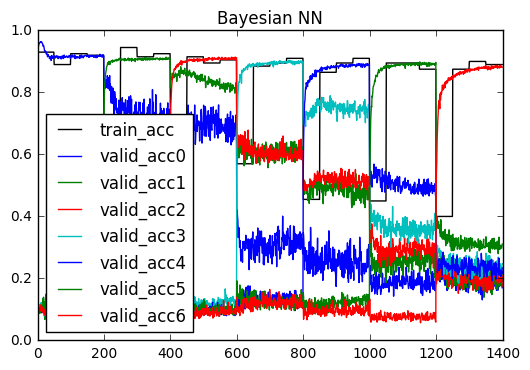

In [49]:
taccs_BNN_OL = taccs
vaccs_BNN_OL = vaccs

plt.title('Bayesian NN')

plt.plot(taccs_BNN_OL, 'k')
plt.plot(vaccs_BNN_OL[0], 'b')
plt.plot(vaccs_BNN_OL[1], 'g')
plt.plot(vaccs_BNN_OL[2], 'r')
plt.plot(vaccs_BNN_OL[3], 'c')
plt.plot(vaccs_BNN_OL[4], 'b')
plt.plot(vaccs_BNN_OL[5], 'g')
plt.plot(vaccs_BNN_OL[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [50]:
print_accs(vaccs_BNN_OL, 0)
print_accs(vaccs_BNN_OL, 199)
print_accs(vaccs_BNN_OL, 399)
print_accs(vaccs_BNN_OL, 599)
print_accs(vaccs_BNN_OL, 799)
print_accs(vaccs_BNN_OL, 999)
print_accs(vaccs_BNN_OL, 1199)
print_accs(vaccs_BNN_OL, 1399)

 0.9145 0.0916 0.0902 0.1231 0.0932 0.1030 0.1025
 0.9182 0.1180 0.1215 0.0889 0.1087 0.1148 0.0879
 0.7037 0.9083 0.1381 0.1306 0.1117 0.0930 0.0894
 0.6335 0.8230 0.9120 0.1344 0.0986 0.1035 0.0967
 0.2789 0.5939 0.6127 0.8986 0.1399 0.1255 0.1238
 0.2679 0.5021 0.5285 0.7523 0.8903 0.1116 0.0857
 0.1888 0.2684 0.2756 0.3519 0.4710 0.8970 0.0591
 0.1699 0.2117 0.1737 0.2476 0.2337 0.3106 0.8818


# Online version + EWC with rho_grad

In [6]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [7]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 10, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, kl_reweight = False, train_rho = True, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

layer done
layer done
(10, ?, 10)
[(<tf.Tensor 'gradients/AddN_4:0' shape=(785, 50) dtype=float32>, <tf.Variable 'layer0/q_pos/mu:0' shape=(785, 50) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_6:0' shape=(785, 50) dtype=float32>, <tf.Variable 'layer0/q_pos/rho:0' shape=(785, 50) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_5:0' shape=(51, 10) dtype=float32>, <tf.Variable 'layer1/q_pos/mu:0' shape=(51, 10) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_7:0' shape=(51, 10) dtype=float32>, <tf.Variable 'layer1/q_pos/rho:0' shape=(51, 10) dtype=float32_ref>)]


In [8]:
print bnn.p_params

[<tf.Variable 'layer0/p_pri/p_mu:0' shape=(785, 50) dtype=float32_ref>, <tf.Variable 'layer0/p_pri/p_rho:0' shape=(785, 50) dtype=float32_ref>, <tf.Variable 'layer1/p_pri/p_mu:0' shape=(51, 10) dtype=float32_ref>, <tf.Variable 'layer1/p_pri/p_rho:0' shape=(51, 10) dtype=float32_ref>]


In [9]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 200
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            bnn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = bnn.get_lr()
                bnn.decay_lr()
                patience = 3

                if bnn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1


        if ep % 50 == 0: bnn.print_ewcgrads(feed)
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    bnn.update_prior()
    #bnn.print_params()




ep 0, batch 0, training accuracy 0.13
f : 202067.484375, q : 142556.625, p : -54963.859375, l : 4606.03759766
ep 0, batch 50, training accuracy 0.895
f : 196452.65625, q : 140581.21875, p : -55011.5507812, l : 933.35949707
ep 0, batch 100, training accuracy 0.87
f : 194493.875, q : 138568.9375, p : -55036.4140625, l : 896.143859863
ep 0, batch 150, training accuracy 0.915
f : 192429.328125, q : 136465.25, p : -55051.4453125, l : 785.247375488
ep 0, batch 200, training accuracy 0.95
f : 190179.296875, q : 134628.6875, p : -55062.9765625, l : 479.551849365
layer0/q_pos/mu:0
max: 46.8344268799, min: -25.1241188049, mean: 0.0800678580999, std: 3.19901609421
layer0/q_pos/rho:0
max: -0.851238965988, min: -1.10114502907, mean: -0.995608866215, std: 0.00652648787946
layer1/q_pos/mu:0
max: 98.2426147461, min: -34.6650733948, mean: -0.00193680590019, std: 13.4347143173
layer1/q_pos/rho:0
max: -0.742455005646, min: -1.13285768032, mean: -0.996328234673, std: 0.0256416592747
valid accuracy: 0.9102

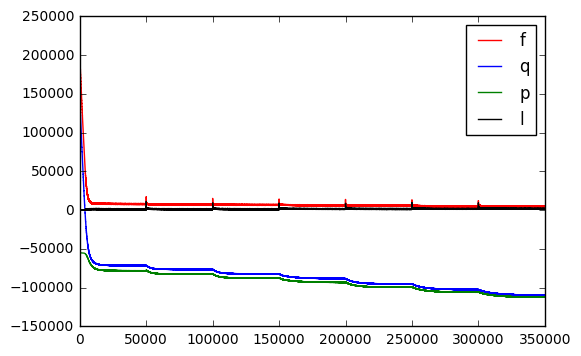

In [10]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

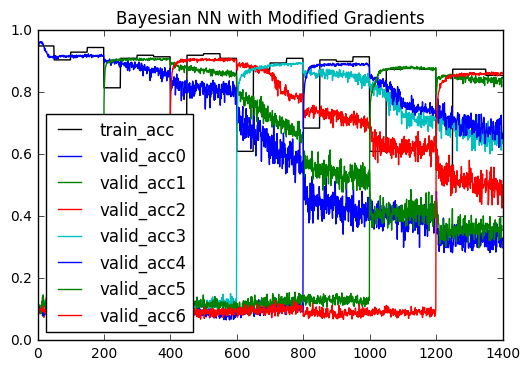

In [11]:
taccs_BNN_MG = taccs
vaccs_BNN_MG = vaccs

plt.title('Bayesian NN with Modified Gradients')
plt.plot(taccs_BNN_MG, 'k')
plt.plot(vaccs_BNN_MG[0], 'b')
plt.plot(vaccs_BNN_MG[1], 'g')
plt.plot(vaccs_BNN_MG[2], 'r')
plt.plot(vaccs_BNN_MG[3], 'c')
plt.plot(vaccs_BNN_MG[4], 'b')
plt.plot(vaccs_BNN_MG[5], 'g')
plt.plot(vaccs_BNN_MG[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [12]:
print_accs(vaccs_BNN_MG, 0)
print_accs(vaccs_BNN_MG, 199)
print_accs(vaccs_BNN_MG, 399)
print_accs(vaccs_BNN_MG, 599)
print_accs(vaccs_BNN_MG, 799)
print_accs(vaccs_BNN_MG, 999)
print_accs(vaccs_BNN_MG, 1199)
print_accs(vaccs_BNN_MG, 1399)

 0.9102 0.1016 0.0905 0.1141 0.0944 0.1002 0.1032
 0.9183 0.1214 0.1202 0.0925 0.0971 0.0984 0.0940
 0.8684 0.9059 0.1086 0.1107 0.1165 0.1088 0.0939
 0.8135 0.8520 0.9032 0.1268 0.0850 0.1118 0.0901
 0.5435 0.6600 0.7819 0.8966 0.0913 0.1344 0.0995
 0.4500 0.5513 0.6957 0.8458 0.8875 0.1297 0.0842
 0.4061 0.3963 0.6227 0.7168 0.7399 0.8797 0.1029
 0.2993 0.3557 0.5018 0.6354 0.6660 0.8454 0.8606


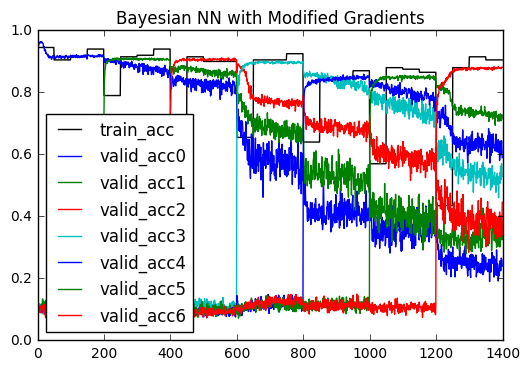

In [11]:
taccs_BNN_MG = taccs
vaccs_BNN_MG = vaccs

plt.title('Bayesian NN with Modified Gradients')
plt.plot(taccs_BNN_MG, 'k')
plt.plot(vaccs_BNN_MG[0], 'b')
plt.plot(vaccs_BNN_MG[1], 'g')
plt.plot(vaccs_BNN_MG[2], 'r')
plt.plot(vaccs_BNN_MG[3], 'c')
plt.plot(vaccs_BNN_MG[4], 'b')
plt.plot(vaccs_BNN_MG[5], 'g')
plt.plot(vaccs_BNN_MG[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [12]:
print_accs(vaccs_BNN_MG, 0)
print_accs(vaccs_BNN_MG, 199)
print_accs(vaccs_BNN_MG, 399)
print_accs(vaccs_BNN_MG, 599)
print_accs(vaccs_BNN_MG, 799)
print_accs(vaccs_BNN_MG, 999)
print_accs(vaccs_BNN_MG, 1199)
print_accs(vaccs_BNN_MG, 1399)

 0.9111 0.0931 0.0929 0.1233 0.0953 0.1018 0.1081
 0.9156 0.1103 0.1054 0.1096 0.0892 0.1030 0.0887
 0.8691 0.9048 0.1110 0.1195 0.1181 0.0867 0.0912
 0.8246 0.8680 0.9049 0.1115 0.0962 0.1020 0.1116
 0.6030 0.6453 0.7642 0.8992 0.0978 0.1004 0.1323
 0.3862 0.4764 0.6839 0.8120 0.8476 0.1032 0.1177
 0.3307 0.4238 0.5051 0.6975 0.7797 0.8427 0.1140
 0.2396 0.3409 0.4457 0.5293 0.5897 0.7270 0.8811


# Normal NN

In [33]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [34]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
nn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = True, ewc = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

layer done
layer done
(?, 10)


In [35]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    nn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {nn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    nn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = nn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            nn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = nn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = nn.get_lr()
                nn.decay_lr()
                patience = 3

                if nn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(nn.validate({nn.x: x_valid[i], nn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={nn.x: x_valid[d], nn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    nn.update_prior()
    #bnn.print_params()




ep 0, batch 0, training accuracy 0.1
ep 0, batch 50, training accuracy 0.39
ep 0, batch 100, training accuracy 0.4
ep 0, batch 150, training accuracy 0.625
ep 0, batch 200, training accuracy 0.755
valid accuracy: 0.7971 0.1162 0.1474 0.095 0.0873 0.143 0.1103
valid accuracy: 0.8772 0.093 0.1342 0.0895 0.092 0.1334 0.1
valid accuracy: 0.9018 0.0906 0.1216 0.1005 0.093 0.1224 0.0985
valid accuracy: 0.9088 0.0911 0.1143 0.1072 0.0916 0.1206 0.0967
valid accuracy: 0.9162 0.0919 0.1076 0.1097 0.091 0.1185 0.095
valid accuracy: 0.9209 0.0931 0.1035 0.1107 0.0896 0.1193 0.0941
valid accuracy: 0.9252 0.0933 0.1021 0.1098 0.088 0.1189 0.0937
valid accuracy: 0.9284 0.0942 0.102 0.1112 0.0864 0.1183 0.0936
valid accuracy: 0.9316 0.0959 0.1008 0.1108 0.0853 0.1173 0.0934
valid accuracy: 0.9333 0.0977 0.0998 0.111 0.0851 0.1169 0.0931
valid accuracy: 0.9363 0.0975 0.1003 0.11 0.0857 0.1161 0.0921
valid accuracy: 0.9382 0.0985 0.1019 0.1105 0.0854 0.1163 0.0911
valid accuracy: 0.9406 0.1006 0.1018 0

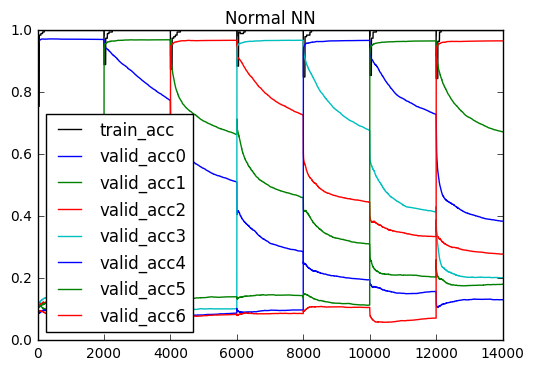

In [36]:
taccs_nNN = taccs
vaccs_nNN = vaccs

plt.title('Normal NN')

plt.plot(taccs_nNN, 'k')
plt.plot(vaccs_nNN[0], 'b')
plt.plot(vaccs_nNN[1], 'g')
plt.plot(vaccs_nNN[2], 'r')
plt.plot(vaccs_nNN[3], 'c')
plt.plot(vaccs_nNN[4], 'b')
plt.plot(vaccs_nNN[5], 'g')
plt.plot(vaccs_nNN[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [38]:
print_accs(vaccs_nNN, 0)
print_accs(vaccs_nNN, 1999)
print_accs(vaccs_nNN, 3999)
print_accs(vaccs_nNN, 5999)
print_accs(vaccs_nNN, 7999)
print_accs(vaccs_nNN, 9999)
print_accs(vaccs_nNN, 11999)
print_accs(vaccs_nNN, 13999)

 0.7971 0.1162 0.1474 0.0950 0.0873 0.1430 0.1103
 0.9709 0.0987 0.1294 0.1281 0.0854 0.1259 0.0839
 0.7743 0.9699 0.1293 0.1288 0.1072 0.1267 0.0894
 0.5113 0.6639 0.9682 0.1021 0.0882 0.1408 0.0840
 0.2869 0.4611 0.7268 0.9682 0.0983 0.1449 0.0867
 0.1955 0.3105 0.4466 0.6777 0.9679 0.1140 0.1067
 0.1584 0.2041 0.3351 0.4148 0.7299 0.9662 0.0721
 0.1314 0.1813 0.2786 0.2023 0.3849 0.6730 0.9663


# Normal NN + EWC

In [9]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.4)))


In [10]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
enn = nn_shson.nn_model([784, 50, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-3, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

layer done
layer done
(?, 10)


In [11]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    enn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {enn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    enn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = enn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            enn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = enn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = enn.get_lr()
                enn.decay_lr()
                patience = 3

                if enn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(enn.validate({enn.x: x_valid[i], enn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={enn.x: x_valid[d], enn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

    #     if i > 10 and np.mean(vaccs[-10:-5]) < np.mean(vaccs[-5:]):
    #         bnn.decay_lr()

    enn.update_prior()
    #bnn.print_params()




ep 0, batch 0, training accuracy 0.13
ep 0, batch 50, training accuracy 0.25
ep 0, batch 100, training accuracy 0.14
ep 0, batch 150, training accuracy 0.275
ep 0, batch 200, training accuracy 0.25
valid accuracy: 0.3646 0.1064 0.1064 0.1064 0.1064 0.1064 0.1064
valid accuracy: 0.4539 0.1057 0.1096 0.1066 0.1065 0.1069 0.1065
valid accuracy: 0.5254 0.1055 0.1082 0.1089 0.1078 0.1102 0.1094
valid accuracy: 0.5911 0.1319 0.1832 0.1537 0.0995 0.2384 0.166
valid accuracy: 0.6284 0.1163 0.1129 0.0997 0.0819 0.162 0.1077
valid accuracy: 0.6615 0.1242 0.1019 0.0962 0.0898 0.153 0.1021
valid accuracy: 0.6862 0.1227 0.102 0.0934 0.0949 0.1471 0.0993
valid accuracy: 0.7136 0.1172 0.1068 0.0925 0.0958 0.1449 0.0979
valid accuracy: 0.739 0.1157 0.1098 0.0932 0.0947 0.1437 0.0998
valid accuracy: 0.7585 0.1086 0.1117 0.0929 0.0951 0.1408 0.1031
valid accuracy: 0.7694 0.1029 0.1156 0.0944 0.0947 0.1394 0.1053
valid accuracy: 0.7797 0.0989 0.1163 0.0928 0.0952 0.1391 0.1066
valid accuracy: 0.7877 0.09

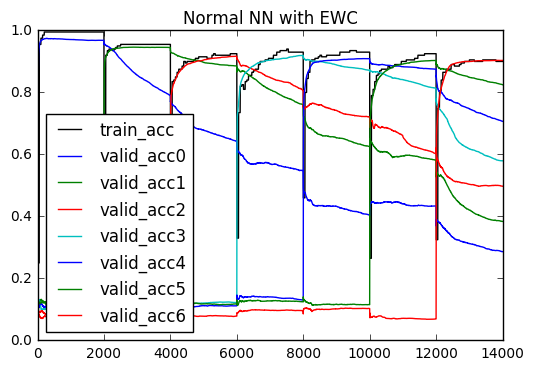

In [12]:
taccs_NNEWC = taccs
vaccs_NNEWC = vaccs

plt.title('Normal NN with EWC')
plt.plot(taccs_NNEWC, 'k')
plt.plot(vaccs_NNEWC[0], 'b')
plt.plot(vaccs_NNEWC[1], 'g')
plt.plot(vaccs_NNEWC[2], 'r')
plt.plot(vaccs_NNEWC[3], 'c')
plt.plot(vaccs_NNEWC[4], 'b')
plt.plot(vaccs_NNEWC[5], 'g')
plt.plot(vaccs_NNEWC[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [13]:
print_accs(vaccs_NNEWC, 0)
print_accs(vaccs_NNEWC, 1999)
print_accs(vaccs_NNEWC, 3999)
print_accs(vaccs_NNEWC, 5999)
print_accs(vaccs_NNEWC, 7999)
print_accs(vaccs_NNEWC, 9999)
print_accs(vaccs_NNEWC, 11999)
print_accs(vaccs_NNEWC, 13999)

 0.3646 0.1064 0.1064 0.1064 0.1064 0.1064 0.1064
 0.9681 0.0906 0.0890 0.1210 0.1270 0.1203 0.0866
 0.7902 0.9448 0.1094 0.1026 0.1070 0.1477 0.0660
 0.6424 0.8851 0.9172 0.1223 0.1117 0.1180 0.0786
 0.5483 0.7598 0.8060 0.9195 0.1305 0.1251 0.0957
 0.4036 0.6247 0.7209 0.8712 0.9089 0.1155 0.1028
 0.4337 0.5817 0.6022 0.8127 0.8751 0.9031 0.0696
 0.2865 0.3840 0.4976 0.5795 0.7071 0.8251 0.9033


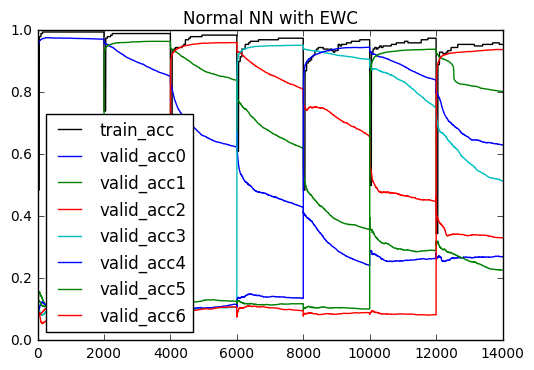

In [42]:
taccs_NNEWC = taccs
vaccs_NNEWC = vaccs

plt.title('Normal NN with EWC')
plt.plot(taccs_NNEWC, 'k')
plt.plot(vaccs_NNEWC[0], 'b')
plt.plot(vaccs_NNEWC[1], 'g')
plt.plot(vaccs_NNEWC[2], 'r')
plt.plot(vaccs_NNEWC[3], 'c')
plt.plot(vaccs_NNEWC[4], 'b')
plt.plot(vaccs_NNEWC[5], 'g')
plt.plot(vaccs_NNEWC[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [43]:
print_accs(vaccs_NNEWC, 0)
print_accs(vaccs_NNEWC, 1999)
print_accs(vaccs_NNEWC, 3999)
print_accs(vaccs_NNEWC, 5999)
print_accs(vaccs_NNEWC, 7999)
print_accs(vaccs_NNEWC, 9999)
print_accs(vaccs_NNEWC, 11999)
print_accs(vaccs_NNEWC, 13999)

 0.5662 0.1146 0.1724 0.1135 0.1191 0.1505 0.1186
 0.9719 0.0972 0.0846 0.1176 0.0921 0.1090 0.0882
 0.8532 0.9645 0.0776 0.0662 0.0903 0.1432 0.1212
 0.6239 0.8381 0.9610 0.1059 0.1166 0.1258 0.1079
 0.4306 0.6193 0.8103 0.9521 0.1356 0.1187 0.0960
 0.2423 0.3570 0.6579 0.9063 0.9458 0.1016 0.0897
 0.2647 0.2893 0.4488 0.7498 0.8392 0.9401 0.0827
 0.2704 0.2269 0.3313 0.5138 0.6304 0.8025 0.9384
